# Ablations Demo

In [1]:
!nvidia-smi

Fri Jul 14 11:53:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           On | 00000000:56:00.0 Off |                    0 |
| N/A   39C    P0               56W / 300W|      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import pickle
import os

sys.path.append("../../dev")
from utils import *
from hooks import *
from model import *
from prefixes import *
from metrics import *
from visualize import *

sys.path.append("../../model")
from model_params import *

sys.path.append("../../data")
from dataset_params import *
from prompt_params import *
from demo_params import *

## 1) Setup

Pick \
(1) Model (gpt_j, gpt2_xl, gpt_neox) \
(2) Dataset (sst2, unnatural, agnews, etc) \
(3) Setting (permuted_incorrect_labels, half_permuted_incorrect_labels, random_labels, etc)

In [4]:
model_name = "gpt_j"
dataset = "sst2"
setting = "permuted_incorrect_labels"
prompt_format_indx = 0 # use first prompt format
num_inputs = 250
num_demos = 40

In [5]:
model_params = MODEL_PARAMS[model_name]
dataset_params = DATASET_PARAMS[dataset]
prompt_params = PROMPT_PARAMS[dataset][prompt_format_indx]
demo_params = DEMO_PARAMS[setting]

## 2) Get Model and Tokenizer

In [6]:
file_path = model_params["file_path"]
model, tokenizer = get_model_and_tokenizer(file_path)

## 3) Get Dataset

In [7]:
print("*Fetch data.*")
dataset = get_dataset(dataset_params)

print(f"There are {len(dataset)} classes.")
print(f"There are {len(dataset[0])} examples per class.")

*Fetch data.*


Found cached dataset sst2 (/tmp/.xdg_cache_dhalawi/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


There are 2 classes.
There are 29780 examples per class.


## 4) Construct Prefixes

In [8]:
print("*Build prefixes.*")
prefixes = Prefixes(
    dataset, prompt_params, demo_params, model_params, tokenizer, num_inputs, num_demos
)

print("True prefix example:")
print("--------------------")
print(prefixes.true_prefixes[0])

print("False prefix example:")
print("---------------------")
print(prefixes.false_prefixes[0])

*Build prefixes.*
True prefix example:
--------------------
Review: a brutal 90-minute battle sequence that does everything but issue you a dog-tag and an m-16 
Answer: Positive.

Review: that takes such a speedy swan dive from `` promising '' 
Answer: Negative.

Review: if you saw it on tv , you 'd probably turn it off , convinced that you had already seen that movie . 
Answer: Negative.

Review: first-time director joão pedro rodrigues ' unwillingness to define his hero 's background or motivations 
Answer: Negative.

Review: alas , it collapses like an overcooked soufflé . 
Answer: Negative.

Review: to ignite sparks 
Answer: Positive.

Review: enactments , however fascinating they may be as history , 
Answer: Positive.

Review: is hugely overwritten , 
Answer: Negative.

Review: sensuality 
Answer: Positive.

Review: subzero 
Answer: Negative.

Review: watching the proverbial paint dry would be a welcome improvement 
Answer: Negative.

Review: 's hard to imagine any recent film , i

### Metrics Helper Function

In [9]:
def get_calibrated_accuracy(
    norm_probs: torch.tensor,
):
    n_labels = norm_probs.shape[-1]
    quantiles, means = get_thresholds(norm_probs, n_labels)

    cal_correct_over_incorrect = get_cal_correct_over_incorrect(
        norm_probs, quantiles, prefixes.true_prefixes_labels
    )

    return {
        "cal_correct_over_incorrect": cal_correct_over_incorrect,
    }

## 5) Get Layerwise Results (No Ablation)

In [10]:
print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
_, _, _, norm_probs = get_label_probs_and_top_logits(
    model, prefixes,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

In [11]:
print("*Get calibrated accuracy.*")
metrics_base = get_calibrated_accuracy(norm_probs)

*Get calibrated accuracy.*


## 6) Get Layerwise Results (Head Ablation)

### 6.1) Our Heads

In [12]:
with open("../../results/attention/gpt_j/unnatural_false_induction_heads.pkl", 'rb') as file:
    layer_heads = pickle.load(file)
layer_heads = [layer_heads] * num_inputs * 2

abl_params = {
    "type": "heads",
    "layer_heads": layer_heads,
    "hook": zero_ablate_heads,
    
}

print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
_, _, _, norm_probs = get_label_probs_and_top_logits(
    model, prefixes, abl_params,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

In [13]:
print("*Get calibrated accuracy.*")
metrics_heads_ours = get_calibrated_accuracy(norm_probs)

*Get calibrated accuracy.*


### 6.2) Random Heads

In [14]:
# Random Heads
num_heads = model_params["num_heads"]
num_layers = model_params["num_layers"]
num_heads_select = 5
layer_heads = []
for i in range(num_inputs * 2):
    samp = {}
    count = 0
    while count < num_heads_select:
        layer, head = (
            random.randint(0, num_heads),
            random.randint(0, num_layers),
        )
        if layer not in samp:
            samp[layer] = []
        if head not in samp[layer]:
            samp[layer].append(head)
            count += 1
    layer_heads.append(samp)

In [15]:
abl_params = {
    "type": "heads",
    "layer_heads": layer_heads,
    "hook": zero_ablate_heads,

}

print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
_, _, _, norm_probs = get_label_probs_and_top_logits(
    model, prefixes, abl_params,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

In [16]:
print("*Get calibrated accuracy.*")
metrics_heads_null = get_calibrated_accuracy(norm_probs)

*Get calibrated accuracy.*


## 7) Get Layerwise Results (Attention Ablation)

In [17]:
with open(f'../../results/critical_layers/critical_layers.pkl', 'rb') as file:
    critical_layers = pickle.load(file)
critical_layer = critical_layers[model_params["model_name"]]

layers = [i for i in range(critical_layer, model_params["num_layers"])]

abl_params = {
    "type": "attention",
    "layers": layers,
    "hook": zero_ablate,
}

print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
_, _, _, norm_probs = get_label_probs_and_top_logits(
    model, prefixes, abl_params,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

In [18]:
metrics_attn = get_calibrated_accuracy(norm_probs)

## 8) Get Layerwise Results (MLP Ablation)

In [19]:
with open(f'../../results/critical_layers/critical_layers.pkl', 'rb') as file:
    critical_layers = pickle.load(file)
critical_layer = critical_layers[model_params["model_name"]]

layers = [i for i in range(critical_layer, model_params["num_layers"])]

abl_params = {
    "type": "mlp",
    "layers": layers,
    "hook": zero_ablate,
}

print(
    "*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*"
)
_, _, _, norm_probs = get_label_probs_and_top_logits(
    model, prefixes, abl_params,
)

*Run inference and get top 1 intermediate logit, top number of labels intermediate logits, probabilities of labels, and normalized probabilities of labels.*
0/500 inputs processed
10/500 inputs processed
20/500 inputs processed
30/500 inputs processed
40/500 inputs processed
50/500 inputs processed
60/500 inputs processed
70/500 inputs processed
80/500 inputs processed
90/500 inputs processed
100/500 inputs processed
110/500 inputs processed
120/500 inputs processed
130/500 inputs processed
140/500 inputs processed
150/500 inputs processed
160/500 inputs processed
170/500 inputs processed
180/500 inputs processed
190/500 inputs processed
200/500 inputs processed
210/500 inputs processed
220/500 inputs processed
230/500 inputs processed
240/500 inputs processed
250/500 inputs processed
260/500 inputs processed
270/500 inputs processed
280/500 inputs processed
290/500 inputs processed
300/500 inputs processed
310/500 inputs processed
320/500 inputs processed
330/500 inputs processed
340/

In [20]:
metrics_mlp = get_calibrated_accuracy(norm_probs)

## 9) Plot Metrics

In [21]:
metrics = {
    "base": metrics_base,
    "our_heads": metrics_heads_ours,
    "rand_heads": metrics_heads_null,
    "attn": metrics_attn,
    "mlp": metrics_mlp,
}

metrics_combined = {}
for _, v in metrics.items():
    for k_, v_ in v.items():
        if k_ not in metrics_combined:
            metrics_combined[k_] = ()
        metrics_combined[k_] += v_

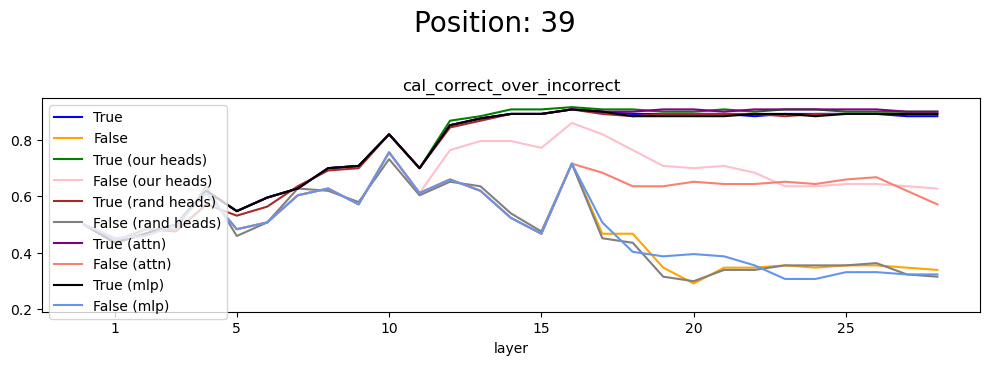

In [22]:
context_pos = model_params["max_demos"] - 1 # index of last demonstration
plot_layerwise_metric_curves(
    metrics_combined,
    context_pos=context_pos,
    pfx_labs=[
        "True",
        "False",
        "True (our heads)",
        "False (our heads)",
        "True (rand heads)",
        "False (rand heads)",
        "True (attn)",
        "False (attn)",
        "True (mlp)",
        "False (mlp)",
    ],
)